# requirements.txt
numpy>=1.24.0

pandas>=2.0.0

scikit-learn>=1.3.0

xgboost>=2.0.0

lightgbm>=4.1.0

optuna>=3.4.0

plotly>=5.18.0

optuna-dashboard>=0.12.0

sqlalchemy>=2.0.0

In [1]:
"""
Methodology:
1. Feature Engineering:
   - Extracts cabin information (Deck, Side)
   - Creates group-based features (GroupSize, Alone)
   - Handles spending patterns and cryosleep
   - Imputes missing values with domain-aware strategies

2. Model Architecture:
   - Uses an ensemble of 4 models:
     * Random Forest
     * XGBoost
     * LightGBM
     * Neural Network (MLP)
   - Each model is wrapped in a pipeline with preprocessing
   - Models are trained using 5-fold cross-validation
   - Predictions are weighted based on individual model performance

3. Preprocessing:
   - Categorical features: One-hot encoding
   - Numerical features: Standardization
   - Missing values: Imputed based on feature type

4. Ensemble Strategy:
   - Weighted average of model predictions
   - Global threshold optimization for final predictions
"""

import warnings

warnings.filterwarnings(
    "ignore", category=UserWarning, message=".*valid feature names.*"
)

import numpy as np
import pandas as pd

# Set pandas option to prevent silent downcasting
pd.set_option("future.no_silent_downcasting", True)

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# 1) Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


# 2) Feature engineering
def process(df):
    """
    Process the input DataFrame by engineering features and handling missing values.

    Feature Engineering:
    - Deck: Extracts deck level from cabin number
    - Side: Extracts side of the ship from cabin number
    - Group: Identifies passenger groups
    - GroupSize: Number of passengers in each group
    - Alone: Binary indicator for solo passengers
    - TotalSpend: Log-transformed total spending across all amenities
    - ZeroSpender: Binary indicator for passengers with no spending

    Missing Value Handling:
    - CryoSleep: Imputed based on spending patterns
    - VIP: Imputed as False
    - Age: Imputed with median
    - HomePlanet: Imputed as Earth
    - Destination: Imputed as TRAPPIST-1e
    - Side: Imputed as P
    - Deck: Imputed as F

    Args:
        df (pd.DataFrame): Input DataFrame with raw passenger data

    Returns:
        pd.DataFrame: Processed DataFrame with engineered features
    """
    df = df.copy()

    df["Deck"] = df["Cabin"].str.split("/").str[0]
    df["Side"] = df["Cabin"].str.split("/").str[2]
    df["Group"] = df["PassengerId"].str.split("_").str[0]
    df["GroupSize"] = df.groupby("Group")["PassengerId"].transform("count")
    df["Alone"] = (df["GroupSize"] == 1).astype(int)

    df["TotalSpend"] = df[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].sum(axis=1)
    df["ZeroSpender"] = (df["TotalSpend"] == 0).astype(int)
    df["TotalSpend"] = np.log1p(df["TotalSpend"])

    df["CryoSleep"] = (
        df["CryoSleep"]
        .fillna(df["ZeroSpender"].map({1: True, 0: np.nan}))
        .infer_objects(copy=False)
    )
    df["CryoSleep"] = df["CryoSleep"].fillna(False).infer_objects(copy=False)
    df["VIP"] = df["VIP"].fillna(False).infer_objects(copy=False)
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["HomePlanet"] = df["HomePlanet"].fillna("Earth")
    df["Destination"] = df["Destination"].fillna("TRAPPIST-1e")
    df["Side"] = df["Side"].fillna("P")
    df["Deck"] = df["Deck"].fillna("F")
    return df


train = process(train)
test = process(test)

X = train.drop(columns=["PassengerId", "Name", "Cabin", "Transported", "Group"])
y = train["Transported"].astype(int)
X_test = test.drop(columns=["PassengerId", "Name", "Cabin", "Group"])

# 3) Define preprocessor
categorical = X.select_dtypes(include="object").columns.tolist()
numerical = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    [
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    (
                        "onehot",
                        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                    ),
                ]
            ),
            categorical,
        ),
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            numerical,
        ),
    ]
)

# 4) Define base models
base_models = {
    "rf": RandomForestClassifier(
        random_state=42,
        n_estimators=450,
        max_depth=12,
        min_samples_split=7,
        min_samples_leaf=3,
        max_features="sqrt",
        n_jobs=-1,
    ),
    "xgb": XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        n_estimators=150,
        learning_rate=0.02029292401725323,
        max_depth=8,
        subsample=0.6042567824306552,
        colsample_bytree=0.7890582809851407,
        min_child_weight=1,
        gamma=0.3091801139027462,
        n_jobs=-1,
    ),
    "lgb": LGBMClassifier(
        random_state=42,
        n_estimators=150,
        learning_rate=0.06656513231113806,
        max_depth=9,
        num_leaves=21,
        subsample=0.952327962978821,
        colsample_bytree=0.586931293046798,
        min_child_samples=18,
        n_jobs=-1,
        verbose=-1,
    ),
    "mlp": MLPClassifier(
        random_state=42,
        hidden_layer_sizes=(64,),
        activation="relu",
        alpha=3.473060351665065e-05,
        learning_rate_init=0.0020861057770138903,
        max_iter=2000,
        tol=1e-3,
        early_stopping=False,
    ),
}

# 5) Create pipelines
pipelines = {
    name: Pipeline([("preproc", preprocessor), ("clf", clone(model))])
    for name, model in base_models.items()
}

# 6) Cross-validated OOF and test predictions
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba = np.zeros((X.shape[0], len(pipelines)))
test_preds = np.zeros((X_test.shape[0], len(pipelines)))
val_scores = {name: [] for name in pipelines}

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

    for i, (name, pipeline) in enumerate(pipelines.items()):
        pipeline.fit(X_tr, y_tr)
        p_val = pipeline.predict_proba(X_va)[:, 1]
        oof_proba[val_idx, i] = p_val
        test_preds[:, i] += pipeline.predict_proba(X_test)[:, 1] / kf.n_splits
        acc = accuracy_score(y_va, (p_val >= 0.5).astype(int))
        val_scores[name].append(acc)
        print(f"Fold {fold} | {name} | acc={acc:.4f}")

# 7) Print per-model mean CV accuracy
mean_scores = {n: np.mean(s) for n, s in val_scores.items()}
for name, score in mean_scores.items():
    print(f"{name} mean CV acc: {score:.4f}")

# 8) Compute ensemble weights
total = sum(mean_scores.values())
weights = {n: mean_scores[n] / total for n in pipelines}
print("Ensemble weights:", weights)

# 9) Global threshold search on OOF
ensemble_oof = oof_proba.dot(np.array([weights[n] for n in pipelines]))
best_thr, best_acc = 0.5, 0.0
for thr in np.arange(0.30, 0.71, 0.01):
    acc = accuracy_score(y, (ensemble_oof >= thr).astype(int))
    if acc > best_acc:
        best_acc, best_thr = acc, thr
print(f"Best threshold: {best_thr:.2f} → CV acc: {best_acc:.4f}")

# 10) Final ensemble predictions
ensemble_test = test_preds.dot(np.array([weights[n] for n in pipelines]))
final_pred = ensemble_test >= best_thr

# 11) Save submission
submission = pd.DataFrame(
    {"PassengerId": test["PassengerId"], "Transported": final_pred}
)
submission.to_csv("submission.csv", index=False)
print("Submission saved.")


Fold 1 | rf | acc=0.8114
Fold 1 | xgb | acc=0.8166
Fold 1 | lgb | acc=0.8125
Fold 1 | mlp | acc=0.8016
Fold 2 | rf | acc=0.7964
Fold 2 | xgb | acc=0.7959
Fold 2 | lgb | acc=0.7993
Fold 2 | mlp | acc=0.8010
Fold 3 | rf | acc=0.8085
Fold 3 | xgb | acc=0.8068
Fold 3 | lgb | acc=0.8143
Fold 3 | mlp | acc=0.8028
Fold 4 | rf | acc=0.8026
Fold 4 | xgb | acc=0.8147
Fold 4 | lgb | acc=0.8188
Fold 4 | mlp | acc=0.8251
Fold 5 | rf | acc=0.7923
Fold 5 | xgb | acc=0.7877
Fold 5 | lgb | acc=0.7934
Fold 5 | mlp | acc=0.7860
rf mean CV acc: 0.8023
xgb mean CV acc: 0.8043
lgb mean CV acc: 0.8077
mlp mean CV acc: 0.8033
Ensemble weights: {'rf': 0.249338363790204, 'xgb': 0.24998203011622952, 'lgb': 0.25101896696295223, 'mlp': 0.24966063913061426}
Best threshold: 0.51 → CV acc: 0.8082
Submission saved.


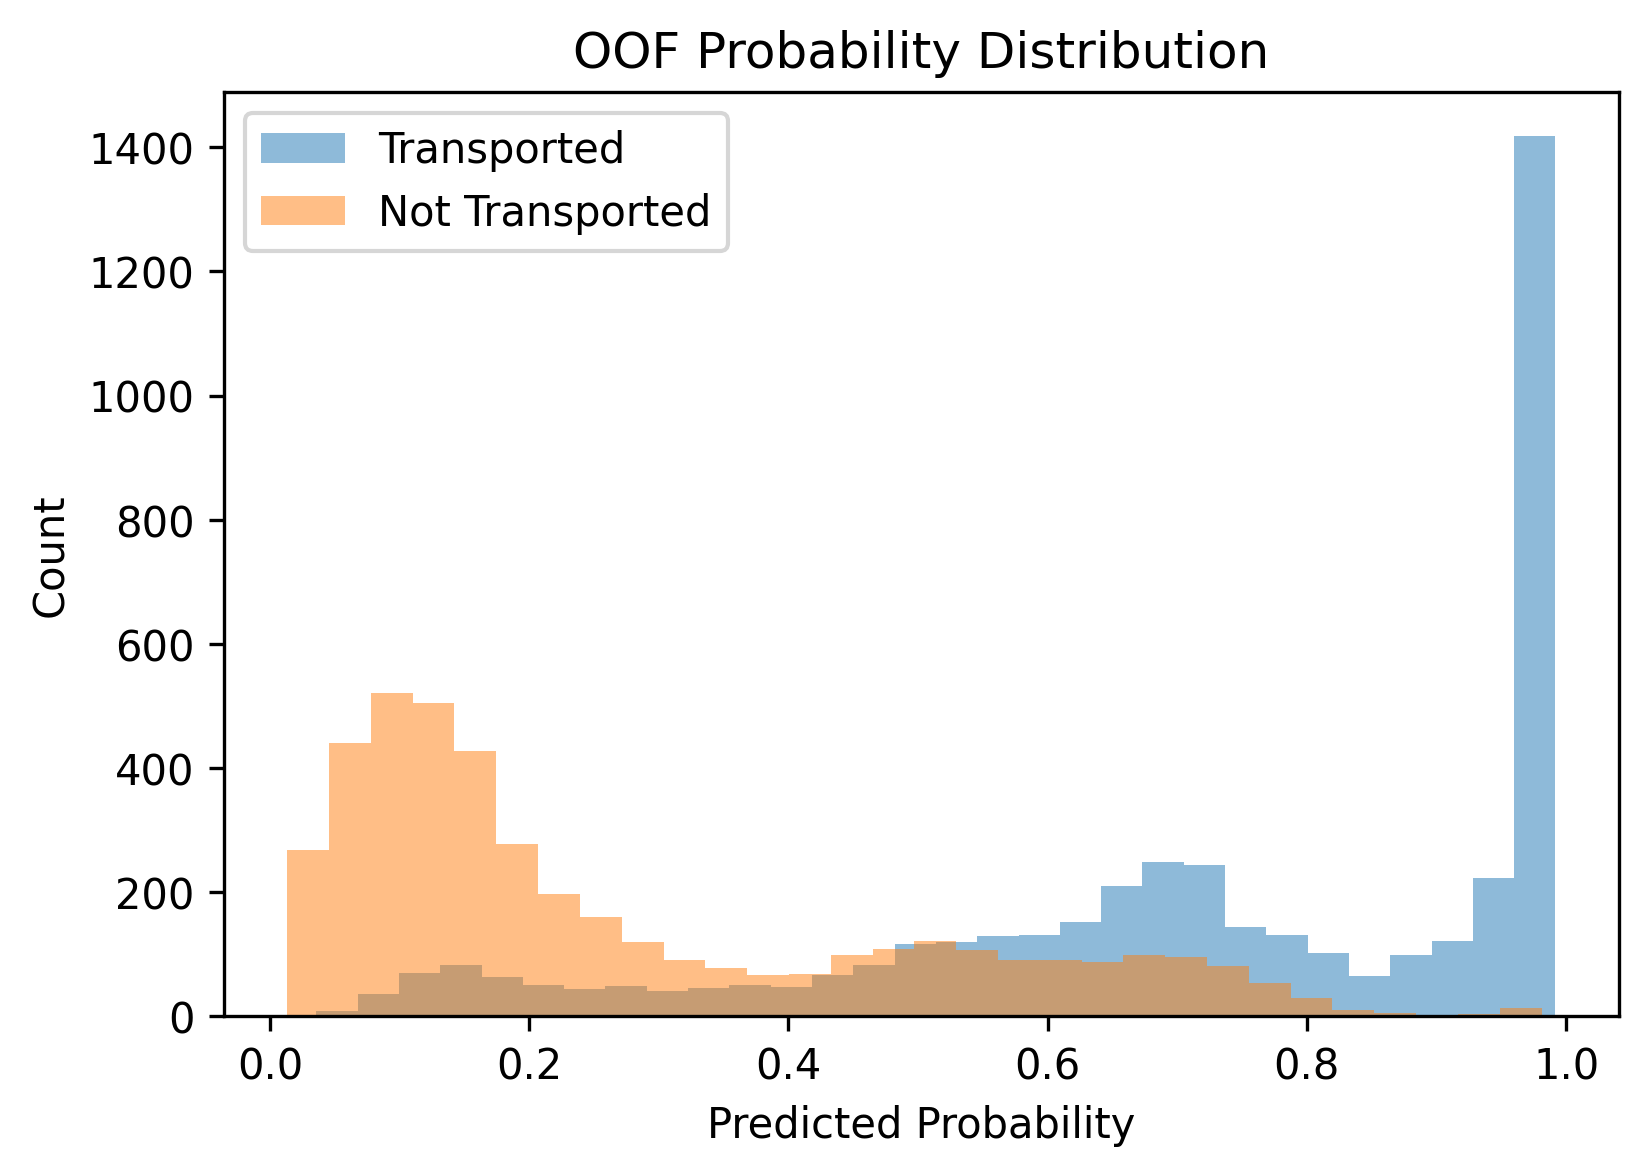

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=300)
plt.hist(ensemble_oof[y==1], bins=30, alpha=0.5, label="Transported")
plt.hist(ensemble_oof[y==0], bins=30, alpha=0.5, label="Not Transported")
plt.legend()
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("OOF Probability Distribution")
plt.show()


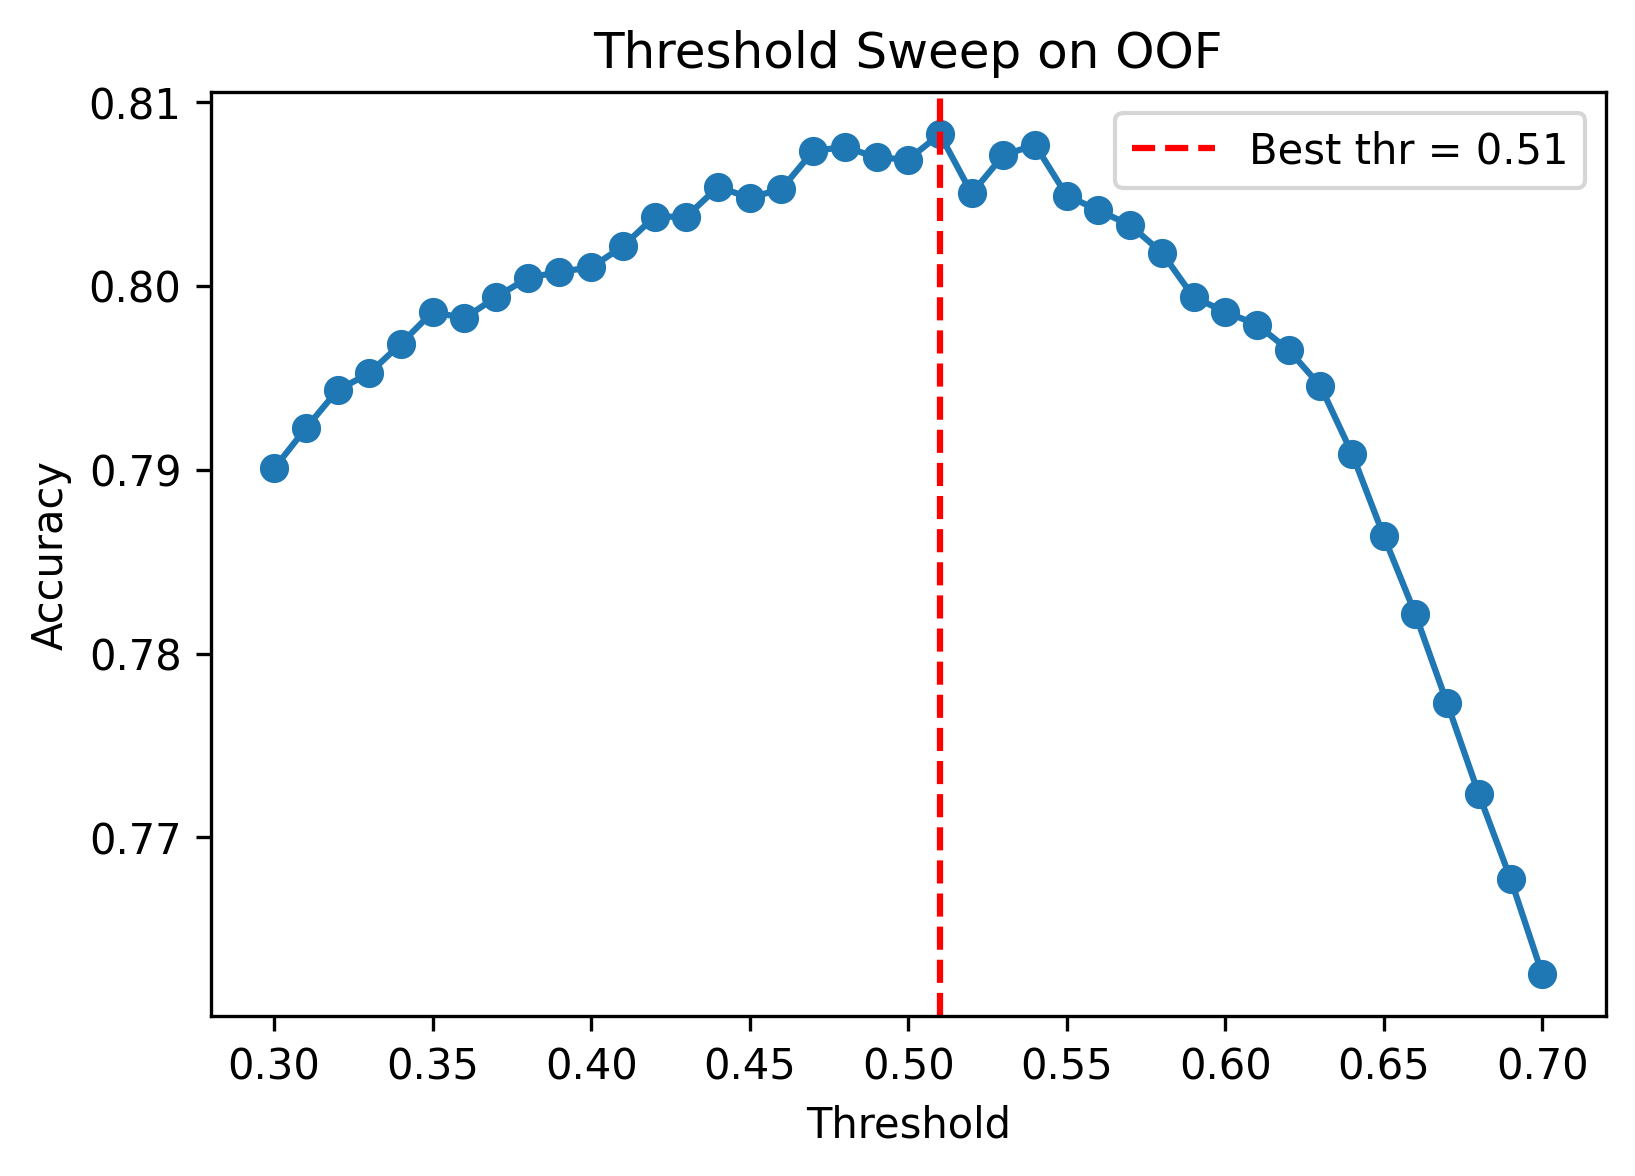

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

thresholds = np.arange(0.30, 0.71, 0.01)
accuracies = [
    accuracy_score(y, (ensemble_oof >= thr).astype(int))
    for thr in thresholds
]

plt.figure(figsize=(6,4), dpi=300)
plt.plot(thresholds, accuracies, marker='o')
best_idx = np.argmax(accuracies)
plt.axvline(thresholds[best_idx], color='red', linestyle='--',
            label=f"Best thr = {thresholds[best_idx]:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Threshold Sweep on OOF")
plt.legend()
plt.show()


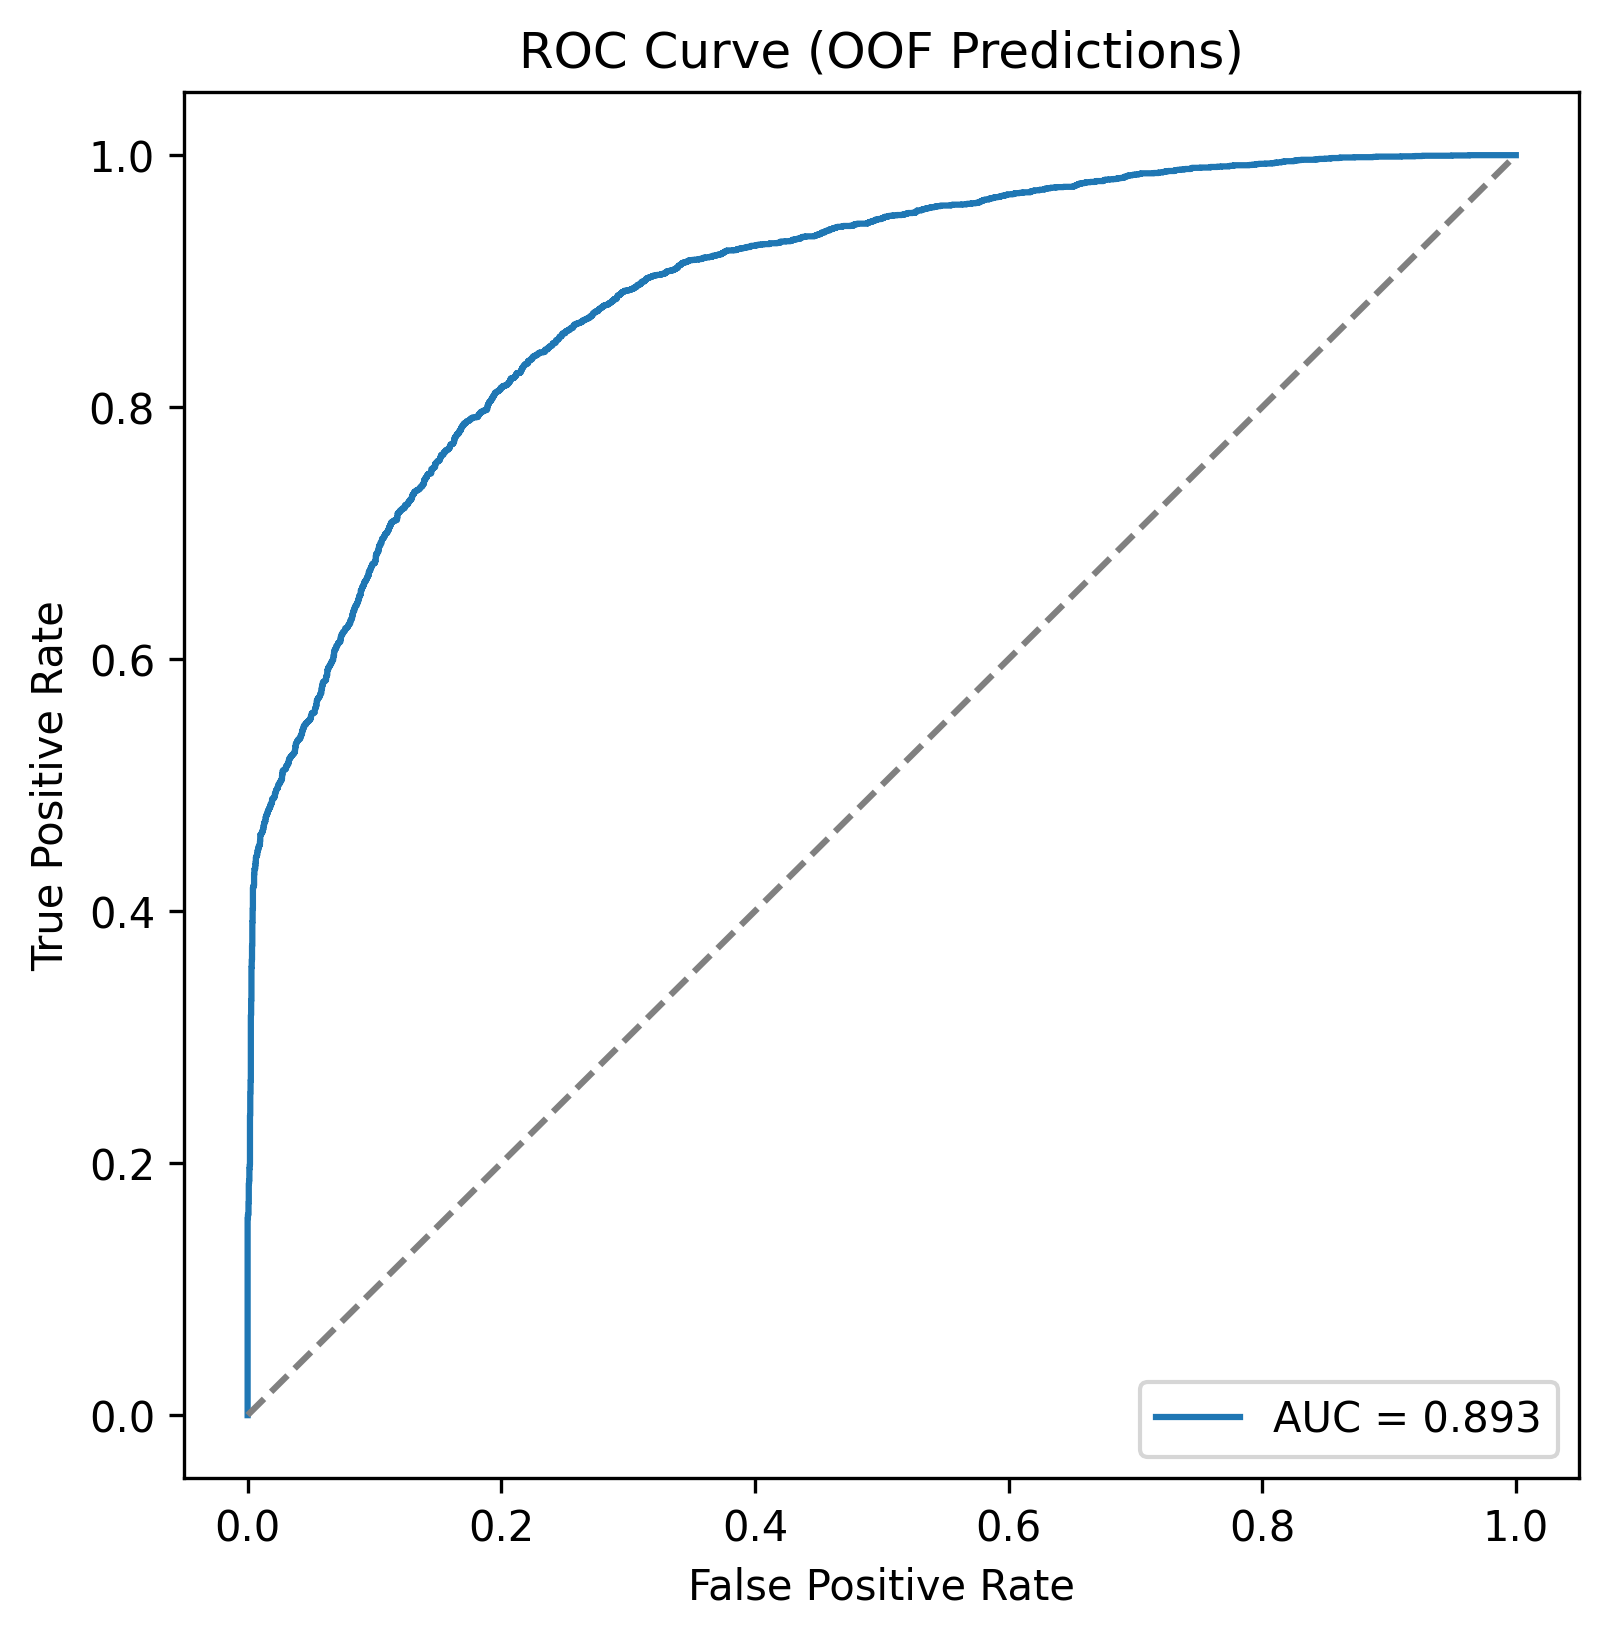

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y, ensemble_oof)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6), dpi=300)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF Predictions)")
plt.legend(loc="lower right")
plt.show()
